In [1]:
import pickle 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Pre-processing
from sklearn.preprocessing import StandardScaler, MinMaxScaler, label_binarize
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler, MinMaxScaler

# Model training
import lightgbm as lgb
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

# Model evaluation
import shap
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.utils.class_weight import compute_sample_weight

### Utility functions

#### Model tuning

In [2]:
def tune_svc(x_train, y_train, target, c_list = [0.0001, 0.001, 0.01, 0.05, 0.1, 0.5, 1.0, 10.0, 50.0, 100.0, 500.0, 1000.0]):
    param_grid = {'C': c_list}
    grid_search = GridSearchCV(LinearSVC(max_iter = 100000000), param_grid, cv=5)
    grid_search.fit(x_train, y_train)
    print(f'Best score for {target}: {grid_search.best_score_}')
    tuned_params = grid_search.best_params_
    return tuned_params

def tune_logreg(x_train, y_train, target, c_list = [0.0001, 0.001, 0.01, 0.05, 0.1, 0.5, 1.0, 10.0, 100.0, 1000.0]):
    param_grid = {'C': c_list}
    grid_search = GridSearchCV(LogisticRegression(random_state=5, max_iter = 100000), param_grid, cv=5)
    grid_search.fit(x_train, y_train)
    print(f'Best score for {target} log.reg. : {grid_search.best_score_}')
    tuned_params = grid_search.best_params_
    return tuned_params

rf_param_grid = {'max_features': ["log2", "sqrt"],
              'n_estimators': [5, 10, 25, 50, 100, 150, 200], 
              'max_depth': [3, 4, 5, 6, 7, 8, 9, 10], 
              'criterion' :['gini', 'entropy']}

def tune_rf(x_train, y_train, target, param_grid):
    grid_search = GridSearchCV(RandomForestClassifier(random_state=5), param_grid, cv=5)
    grid_search.fit(x_train, y_train)
    print(f'Best score for {target} RF : {grid_search.best_score_}')
    tuned_params = grid_search.best_params_
    return tuned_params

def tune_lgbm(x_train, y_train, target, space):
    print(f'{target} lightgbm:')
    def objective(params):
        params = {
            'num_leaves': int(params['num_leaves']),
            'colsample_bytree': '{:.3f}'.format(params['colsample_bytree']),
            'max_depth': int(params['max_depth'])
        }     
        classifier = lgb.LGBMClassifier(
            n_estimators=500,
            learning_rate=0.01,
            verbose=-1,
            **params
        )
        score = cross_val_score(classifier, x_train, y_train, cv=StratifiedKFold()).mean()
        return score

    best2 = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=50)
    return best2

#### Model runs

In [3]:
def calc_auc(x_test, y_test, model, target):
    if target=='binary':
        y_score = model.predict_proba(x_test)[:,1]
    else:
        y_score = model.predict_proba(x_test) 

    roc_auc_macro = roc_auc_score(y_test, y_score, average="macro", multi_class="ovr")
    roc_auc_weighted = roc_auc_score(y_test, y_score, average="weighted", multi_class="ovr")

    print(f"AUC-ROC (macro): {roc_auc_macro:.3f}")
    print(f"AUC-ROC (weighted): {roc_auc_weighted:.3f}")

def run_model(x_train, y_train, x_test, y_test, params, target, model_type):
    # Fit model based on type
    if model_type == 'SVC':
        model = LinearSVC(C=params[target]['C'], max_iter=2_000_000_000).fit(x_train, y_train)
    elif model_type == 'LogReg':
        model = LogisticRegression(C=params[target]['C'], max_iter=10_000_000).fit(x_train, y_train)
    elif model_type == 'RandomForest':
        model = RandomForestClassifier(random_state=5, **params[target]).fit(x_train, y_train)
    elif model_type == 'LightGBM':
        model = lgb.LGBMClassifier(**params).fit(x_train, y_train)
    # Print scores
    print(f'{model_type} ({target}) Training set score: {model.score(x_train, y_train):.3f}')
    print(f'{model_type} ({target}) Test set score: {model.score(x_test, y_test):.3f}')
    # Get preds
    y_pred = model.predict(x_test)
    # Print metrics and matrix
    print(classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    matrix = ConfusionMatrixDisplay(cm)
    matrix.plot(cmap='plasma')
    # Get AUC if not SVC, LinearSVC in SKlearn implementation does not return probabilities
    if model_type != 'SVC':
        calc_auc(x_test, y_test, model, target)
    return model

### Data Import

In [33]:
#read in dataframe of preprocessed data from pre-processing notebook
features = pd.read_excel('df_processed.xlsx')

In [34]:
#visualise data
features.head()

,Unnamed: 0,KMF,Class I TBs,Class II TBs,Number of O,Number of C,H Bond Ratio,SMRVSA5,Number of N3,MW,...,NO2 adj to CH3,NO2 adj to OH,NO2 adj to NH,Rot Bonds,Num Heteroatoms,Total Rings,Aromatic Rings,Aliphatic Rings,VSAEState8,TPSA
0,0,1.659585,1.945910,0.000000,2.564949,1.945910,0.0,0.000000,0,348.096,...,0,0,0,6,18,1,1,0,0.000000,258.84
1,1,1.465264,1.945910,2.564949,2.564949,1.945910,0.0,3.637445,0,438.186,...,0,0,0,6,24,5,0,5,0.000000,278.28
2,2,1.644946,1.609438,2.197225,2.197225,1.609438,0.0,0.000000,0,296.156,...,0,0,0,4,16,1,0,1,-3.798889,185.52
3,3,1.303522,1.386294,1.945910,1.945910,1.386294,0.0,0.000000,0,222.117,...,0,0,0,3,12,1,0,1,-1.778750,139.14
4,4,1.332550,1.386294,0.000000,1.945910,2.079442,0.0,2.069863,0,227.132,...,2,0,0,3,9,1,1,0,1.166659,129.42


In [35]:
features = features.drop('Unnamed: 0',axis=1).rename(columns =
                     {'Num Heteroatoms': 'Number of Heteroatoms',
                      'Total Rings':'Total Number of Rings',
                      'Aromatic Rings':'Number of Aromatic Rings',
                      'Rot Bonds':'Number of Rotatable Bonds',
                      'SMRVSA5':'SMR_VSA5',
                      'MW':'Molecular Weight'})

## Hyperparameter Tuning & Models

LinSVC, LogReg, RF, LightGBM

In [36]:
# read in target sensitivity classification values
targetvalues = pd.read_excel('targets.xlsx')
# convert to a NumPy array & select desired column
binarytarget = targetvalues.iloc[:, 0].to_numpy()

In [37]:
targets=['binary','tertiary','quaternary','quintenary']

In [38]:
X_train, X_test, y_dummy_train, y_dummy_test = train_test_split(features, targetvalues[targets[0]], test_size=0.25, random_state=0)

In [39]:
train_idx = X_train.index
test_idx = X_test.index

In [40]:
y_train_dict = {target: targetvalues.loc[train_idx, target] for target in targets}
y_test_dict = {target: targetvalues.loc[test_idx, target] for target in targets}


### MinMax Scaling

In [41]:
columns_to_scale = ['KMF', 'Class I TBs', 'Class II TBs', 'Number of N3', 'Molecular Weight', 'H Bond Ratio',
       'Oxygen Balance', 'Number of Heteroatoms', 'Total Number of Rings', 'Number of Aromatic Rings', 'Aliphatic Rings', 'SMR_VSA5', 'TPSA', 
                                   'Number of Rotatable Bonds','VSAEState8', 'Number of N']

In [42]:
transformer = ColumnTransformer(
    transformers=[
        ('minmax', MinMaxScaler(), columns_to_scale)
    ],
    remainder='passthrough'  # Leave all other columns untouched
)

X_train_scaled = transformer.fit_transform(X_train)
X_test_scaled = transformer.transform(X_test)

In [43]:
other_features = [col for col in features.columns if col not in columns_to_scale]

In [44]:
all_feature_names = columns_to_scale + other_features

In [45]:
X_train_scaled = pd.DataFrame(X_train_scaled, columns = all_feature_names, index = X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns = all_feature_names, index = X_test.index)

In [46]:
X = pd.concat([X_train_scaled, X_test_scaled], axis = 0)

## Tuning

### Linear SVC

These sections conduct a grid search to find the best values of the hyperparameters for each model & task

In [47]:
svc_params = {}
for target in targets:
    svc_params[target] = tune_svc(X_train_scaled, y_train_dict[target],target)

Best score for binary: 0.7275114155251142
Best score for tertiary: 0.5428462709284627
Best score for quaternary: 0.44337899543378995
Best score for quintenary: 0.38009893455098936


### Logistic Regression

In [56]:
logreg_params = {}
for target in targets:
    logreg_params[target] = tune_logreg(X_train_scaled, y_train_dict[target],target)

Best score for binary log.reg. : 0.7246955859969559
Best score for tertiary log.reg. : 0.5539573820395738
Best score for quaternary log.reg. : 0.44330289193302896
Best score for quintenary log.reg. : 0.38580669710806703


### Random Forests

Skip this and go to optional load step if you don't want to run the whole thing again

In [ ]:
rf_params = {}
for target in targets:
    rf_params[target] = tune_rf(X_train_scaled, y_train_dict[target],target, rf_param_grid)

### LightGBM

In [23]:
space = {
    'num_leaves': hp.quniform('num_leaves', 8, 128, 2),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.3, 1.0),
    'max_depth': hp.uniform('max_depth', 4, 10)
}

In [24]:
lightgb_params = {}
for target in targets:
    lightgb_params[target] = tune_lgbm(X_train_scaled, y_train_dict[target], target, space)

binary lightgbm:
100%|████████████████████████████████████████████████| 50/50 [00:29<00:00,  1.72trial/s, best loss: 0.7578386605783866]
tertiary lightgbm:
100%|█████████████████████████████████████████████████| 50/50 [01:14<00:00,  1.48s/trial, best loss: 0.515296803652968]
quaternary lightgbm:
100%|██████████████████████████████████████████████████| 50/50 [01:42<00:00,  2.06s/trial, best loss: 0.42720700152207]
quintenary lightgbm:
100%|███████████████████████████████████████████████| 50/50 [02:04<00:00,  2.49s/trial, best loss: 0.37233637747336373]


##### Optional: Save or Load params

In [25]:
# Good to save time with future runs of same params: specially for RF/LGBM which can save a few mins
with open('rf_params.pkl', 'wb') as f:
    pickle.dump(rf_params, f)

with open('lgbm_params.pkl', 'wb') as f:
    pickle.dump(lightgb_params, f)

In [49]:
with open('rf_params.pkl', 'rb') as f:
    rf_params = pickle.load(f)

with open('lgbm_params.pkl', 'rb') as f:
    lightgb_params = pickle.load(f)

## Models Run

### Linear SVC

SVC (binary) Training set score: 0.738
SVC (binary) Test set score: 0.795
              precision    recall  f1-score   support

           0       0.73      0.74      0.74        47
           1       0.84      0.83      0.83        75

    accuracy                           0.80       122
   macro avg       0.78      0.79      0.78       122
weighted avg       0.80      0.80      0.80       122

SVC (tertiary) Training set score: 0.623
SVC (tertiary) Test set score: 0.623
              precision    recall  f1-score   support

           0       0.62      0.66      0.64        35
           1       0.53      0.39      0.45        44
           2       0.68      0.84      0.75        43

    accuracy                           0.62       122
   macro avg       0.61      0.63      0.61       122
weighted avg       0.61      0.62      0.61       122

SVC (quaternary) Training set score: 0.548
SVC (quaternary) Test set score: 0.434
              precision    recall  f1-score   support

   

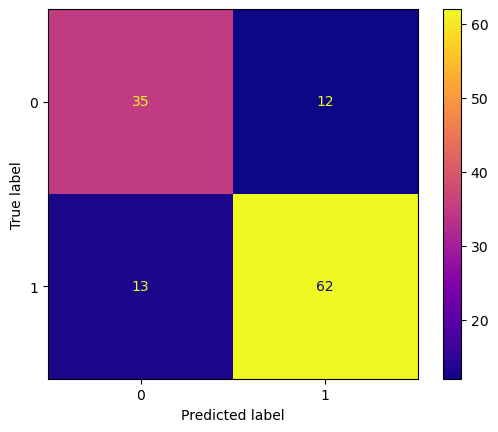

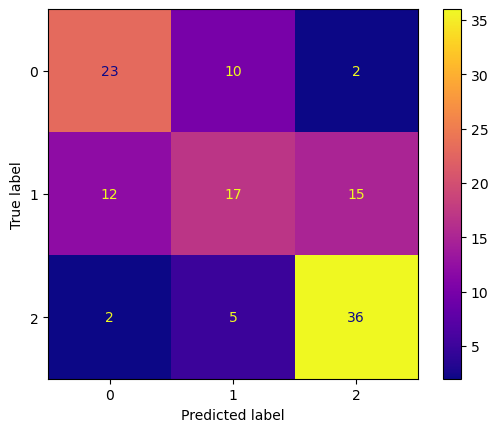

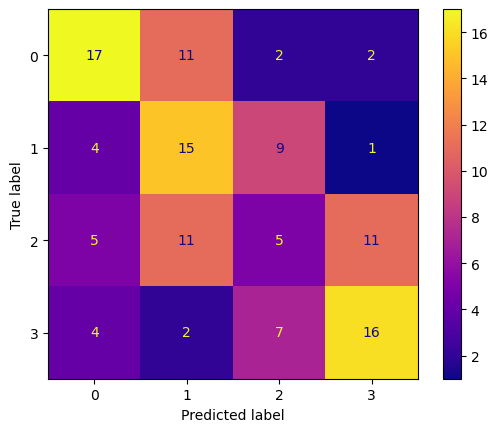

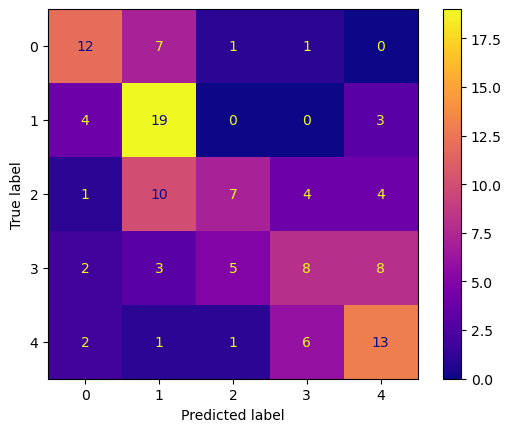

In [50]:
svc_models = {}
for target in targets:
    svc_models[target] = run_model(X_train_scaled, y_train_dict[target], X_test_scaled, y_test_dict[target], svc_params, target, 'SVC')

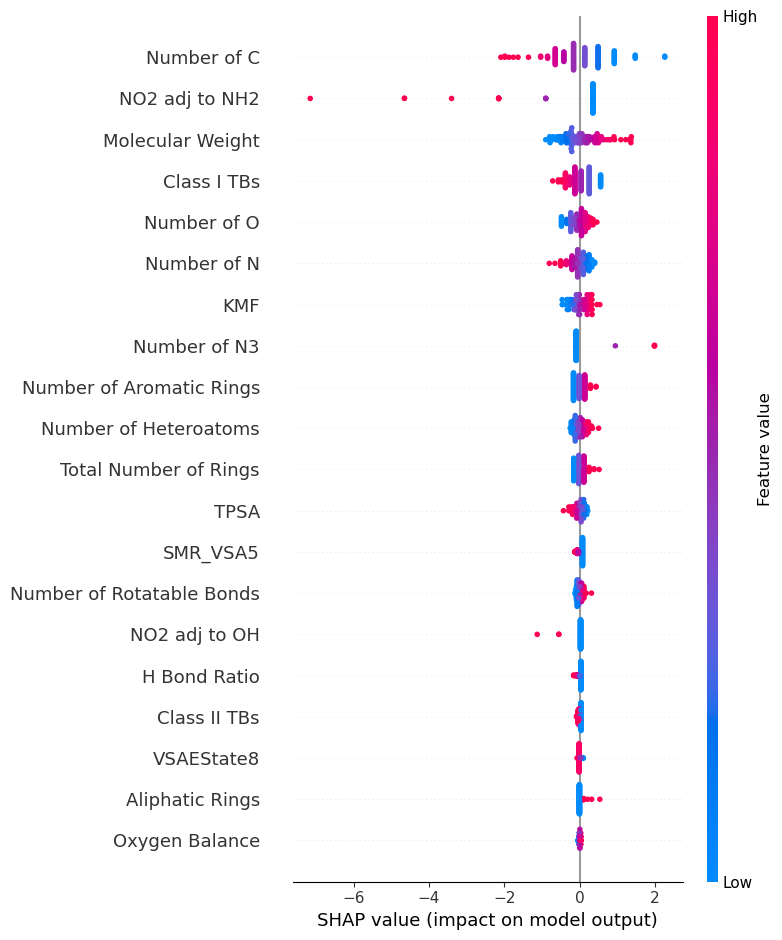

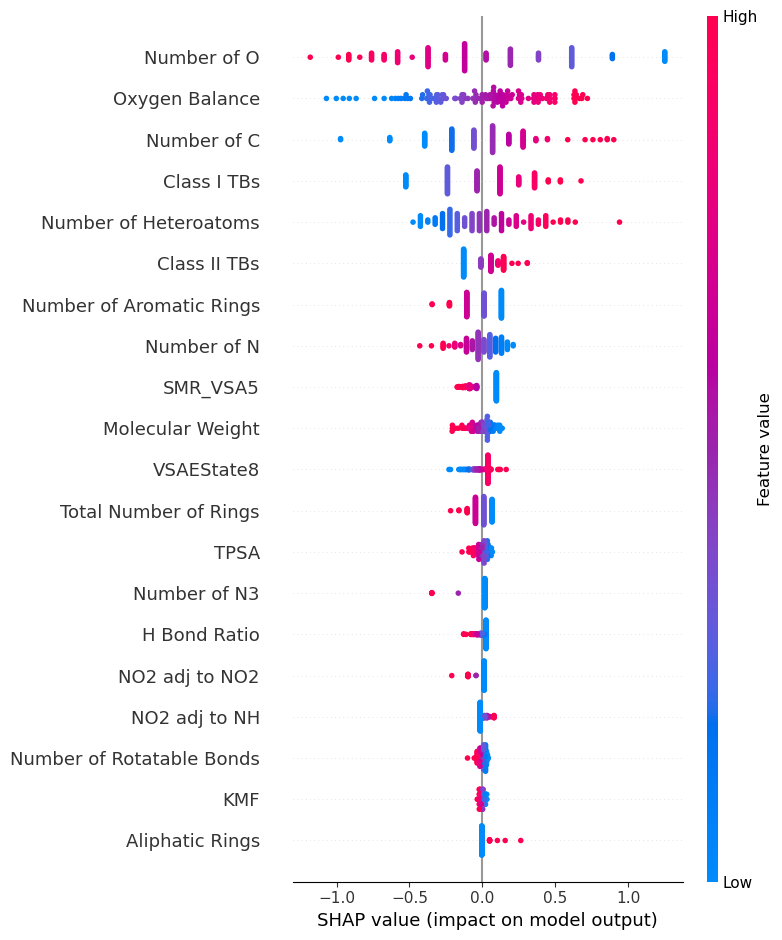

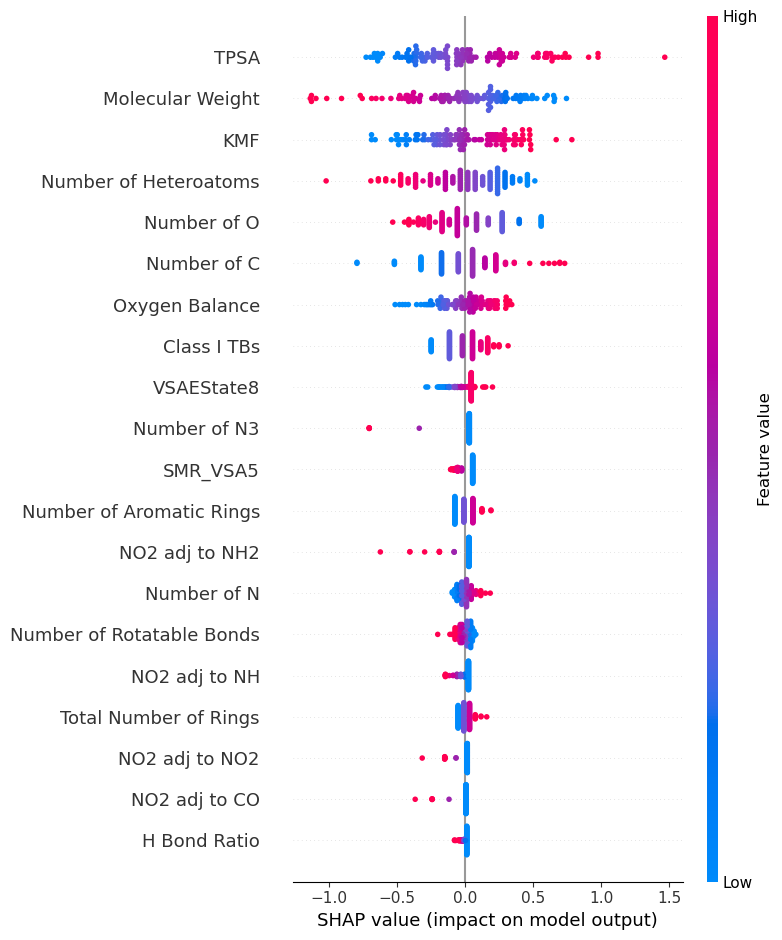

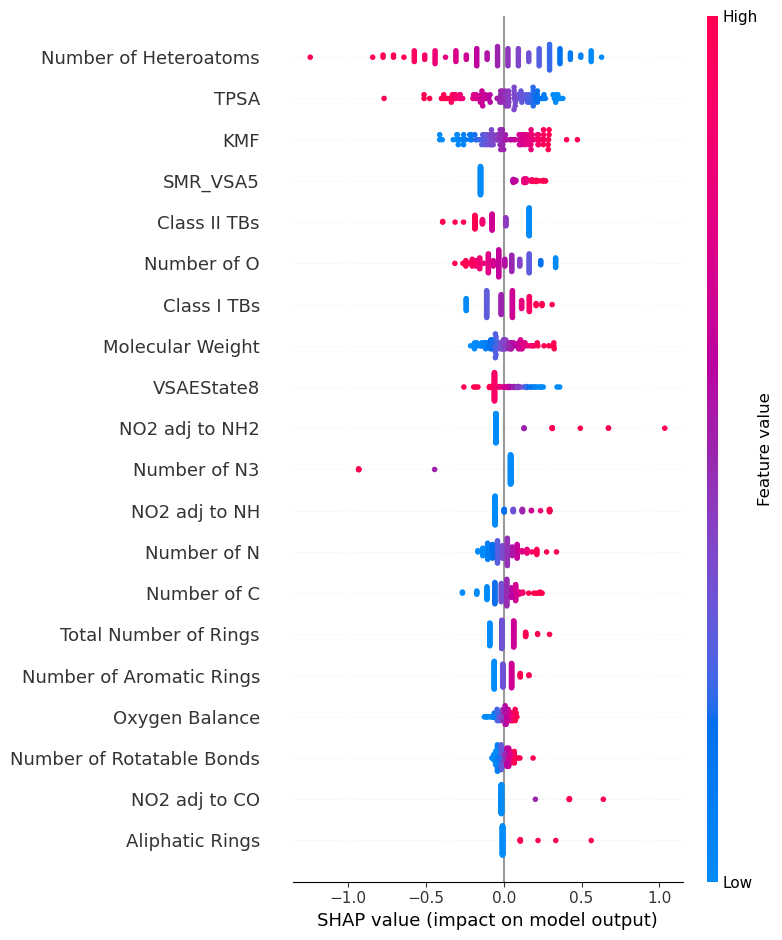

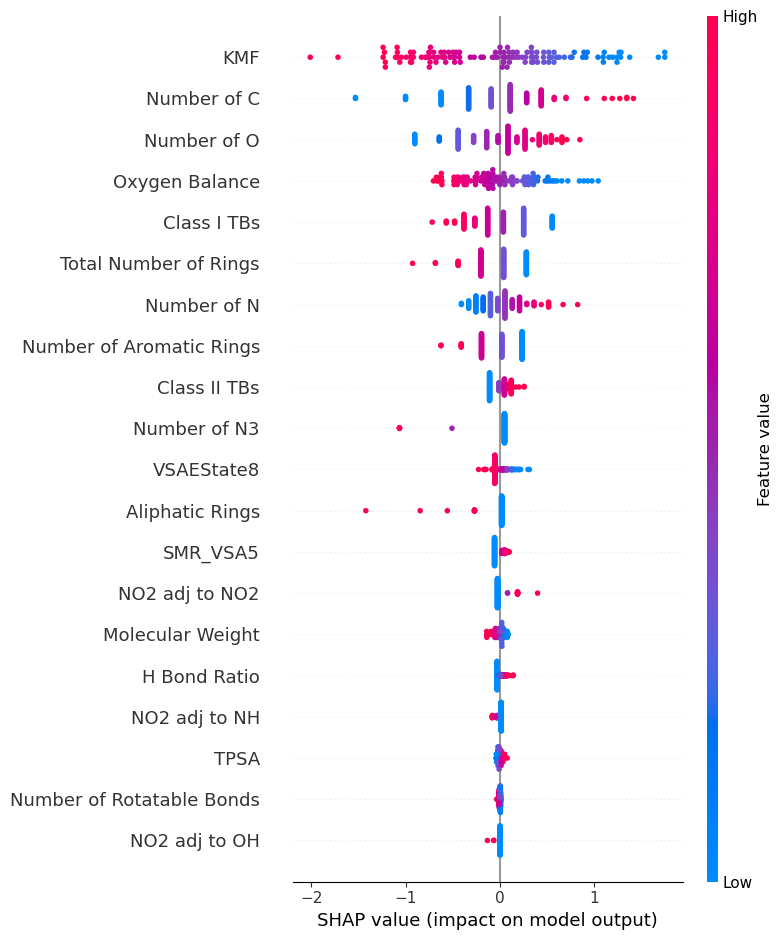

In [51]:
explainer = shap.LinearExplainer(svc_models['quintenary'], X_test_scaled)
shap_values = explainer(X_test_scaled)
for i in range(0,5):
    shap.summary_plot(shap_values[:,:,i], X_test_scaled)

### Logistic Regression

LogReg (binary) Training set score: 0.727
LogReg (binary) Test set score: 0.787
              precision    recall  f1-score   support

           0       0.71      0.74      0.73        47
           1       0.84      0.81      0.82        75

    accuracy                           0.79       122
   macro avg       0.77      0.78      0.78       122
weighted avg       0.79      0.79      0.79       122

AUC-ROC (macro): 0.833
AUC-ROC (weighted): 0.833
LogReg (tertiary) Training set score: 0.634
LogReg (tertiary) Test set score: 0.648
              precision    recall  f1-score   support

           0       0.64      0.66      0.65        35
           1       0.58      0.50      0.54        44
           2       0.71      0.79      0.75        43

    accuracy                           0.65       122
   macro avg       0.64      0.65      0.64       122
weighted avg       0.64      0.65      0.64       122

AUC-ROC (macro): 0.792
AUC-ROC (weighted): 0.787
LogReg (quaternary) Training s

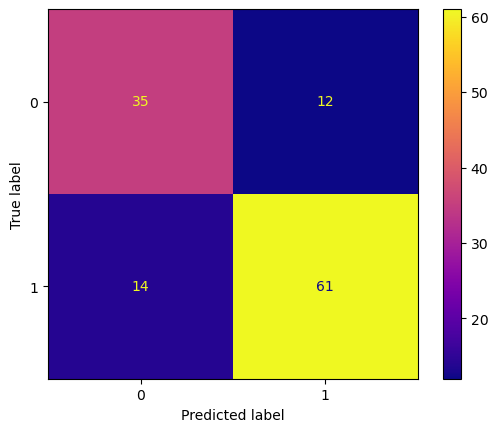

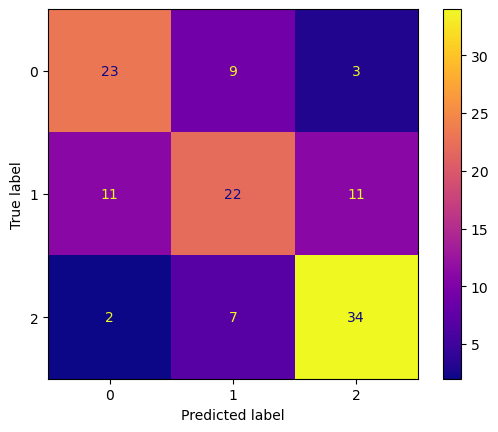

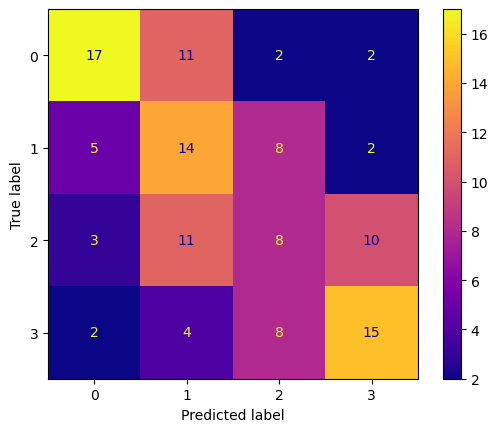

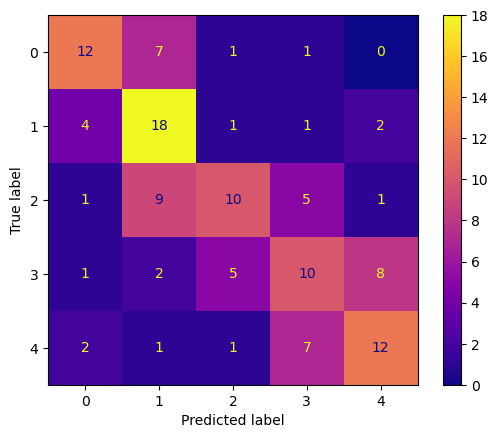

In [57]:
logreg_models = {}
for target in targets:
    logreg_models[target] = run_model(X_train_scaled, y_train_dict[target], X_test_scaled, y_test_dict[target], logreg_params, target, 'LogReg')

### Random Forests

##### Run RF:

RandomForest (binary) Training set score: 0.928
RandomForest (binary) Test set score: 0.795
              precision    recall  f1-score   support

           0       0.73      0.74      0.74        47
           1       0.84      0.83      0.83        75

    accuracy                           0.80       122
   macro avg       0.78      0.79      0.78       122
weighted avg       0.80      0.80      0.80       122

AUC-ROC (macro): 0.846
AUC-ROC (weighted): 0.846
RandomForest (tertiary) Training set score: 0.909
RandomForest (tertiary) Test set score: 0.689
              precision    recall  f1-score   support

           0       0.67      0.74      0.70        35
           1       0.66      0.57      0.61        44
           2       0.73      0.77      0.75        43

    accuracy                           0.69       122
   macro avg       0.69      0.69      0.69       122
weighted avg       0.69      0.69      0.69       122

AUC-ROC (macro): 0.835
AUC-ROC (weighted): 0.831
Random

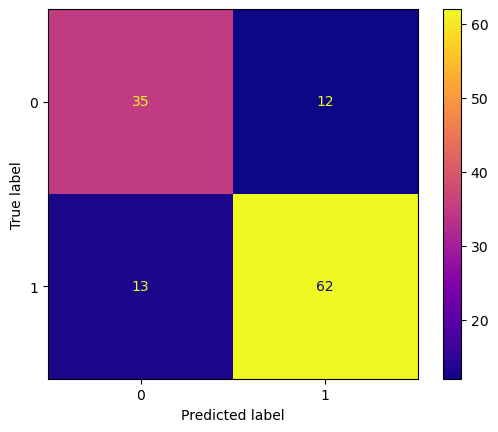

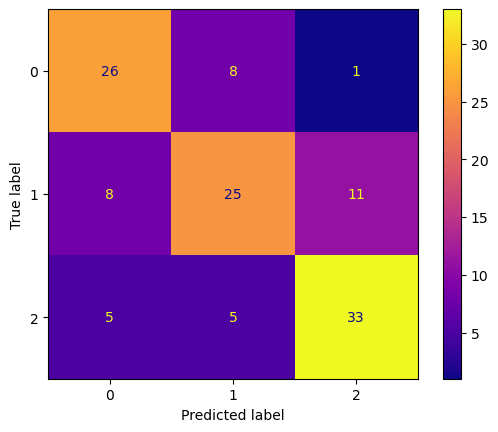

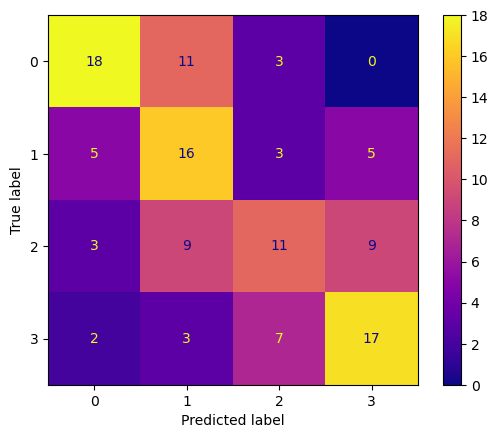

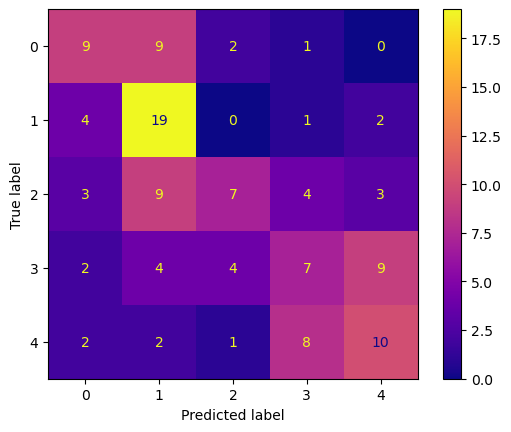

In [53]:
rf_models = {}
for target in targets:
    rf_models[target] = run_model(X_train_scaled, y_train_dict[target], X_test_scaled, y_test_dict[target], rf_params, target, 'RandomForest')

In [64]:
binaryrf =  rf_models['binary'].feature_importances_
np.savetxt("2clsrfimportances_.csv", binaryrf)

threeclsrf =  rf_models['tertiary'].feature_importances_
np.savetxt("3clsrfimportances_.csv", threeclsrf)

fourclsrf = rf_models['quaternary'].feature_importances_
np.savetxt("4clsrfimportances_.csv", fourclsrf)

fiveclsrf = rf_models['quintenary'].feature_importances_
np.savetxt("5clsrfimportances_.csv", fiveclsrf)

In [68]:
from sklearn.inspection import permutation_importance

result = permutation_importance(
    rf_models['quaternary'], X_test_scaled, y_test_dict['quaternary'], n_repeats=10, random_state=42, n_jobs=2
)

forest_importances = pd.Series(result.importances_mean, index=X_test_scaled.columns)

In [69]:
forest_importances

KMF                          0.016393
Class I TBs                  0.020492
Class II TBs                 0.026230
Number of N3                 0.013115
Molecular Weight             0.020492
H Bond Ratio                 0.029508
Oxygen Balance               0.121311
Number of Heteroatoms       -0.008197
Total Number of Rings        0.000820
Number of Aromatic Rings     0.029508
Aliphatic Rings              0.011475
SMR_VSA5                     0.042623
TPSA                         0.036066
Number of Rotatable Bonds    0.035246
VSAEState8                   0.033607
Number of N                  0.018852
Number of O                 -0.013934
Number of C                  0.060656
NO2 adj to NO2               0.002459
NO2 adj to NH2               0.009836
NO2 adj to CO               -0.001639
NO2 adj to CH3               0.000000
NO2 adj to OH               -0.008197
NO2 adj to NH                0.008197
dtype: float64

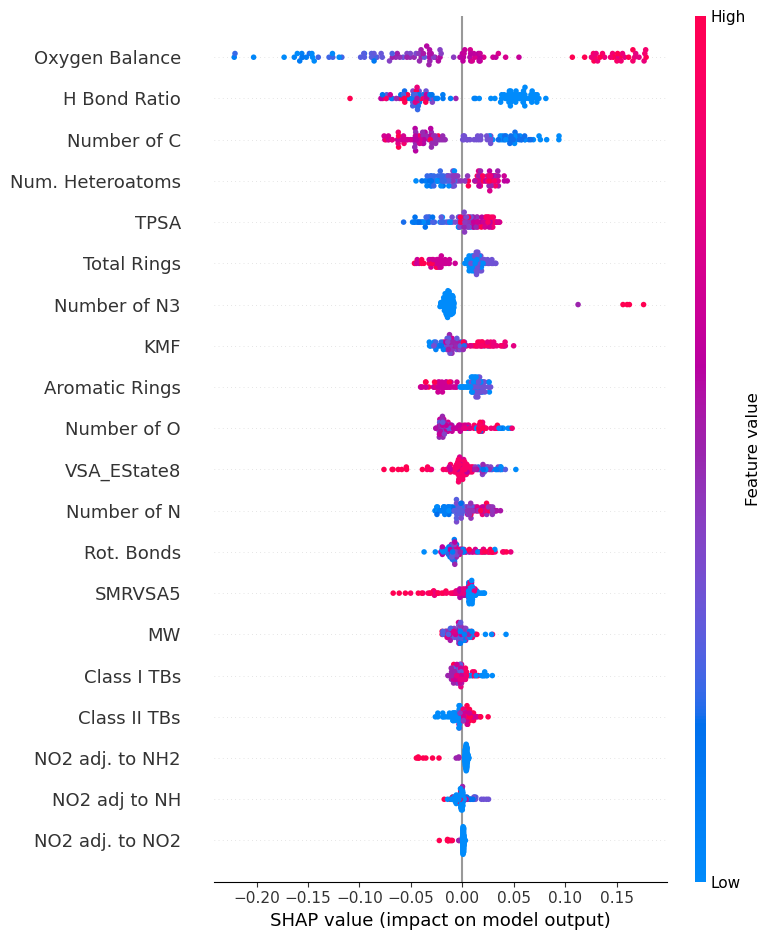

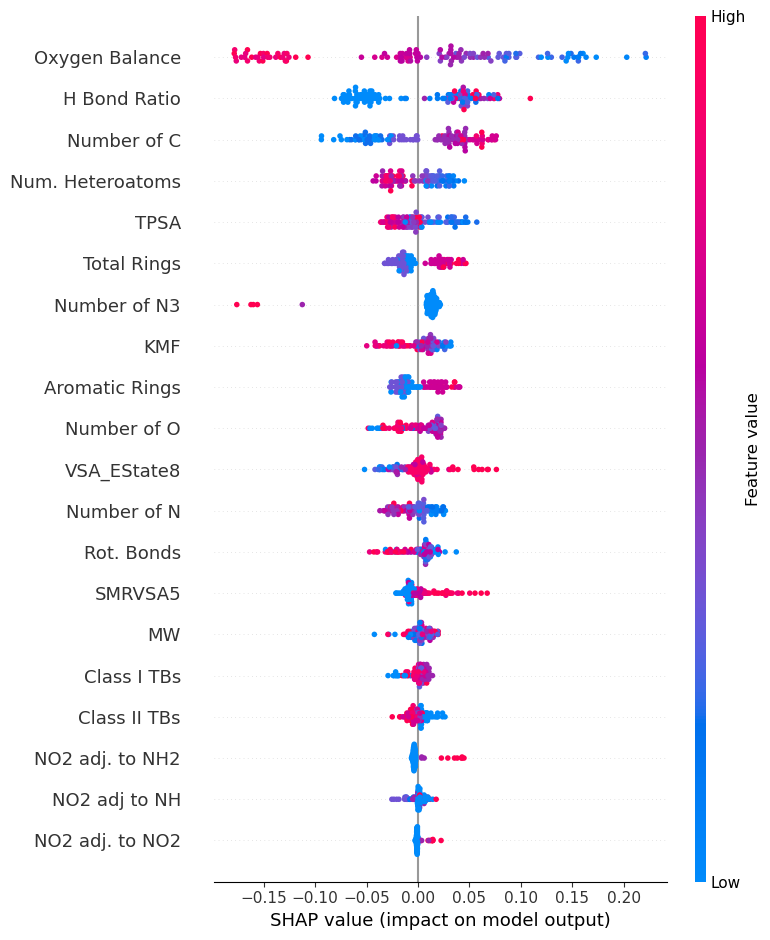

In [26]:
explainer = shap.TreeExplainer(rf_models['binary'])
shap_values = explainer(X_test_scaled)
for i in range(0,2):
    shap.summary_plot(shap_values[:,:,i], X_test_scaled)

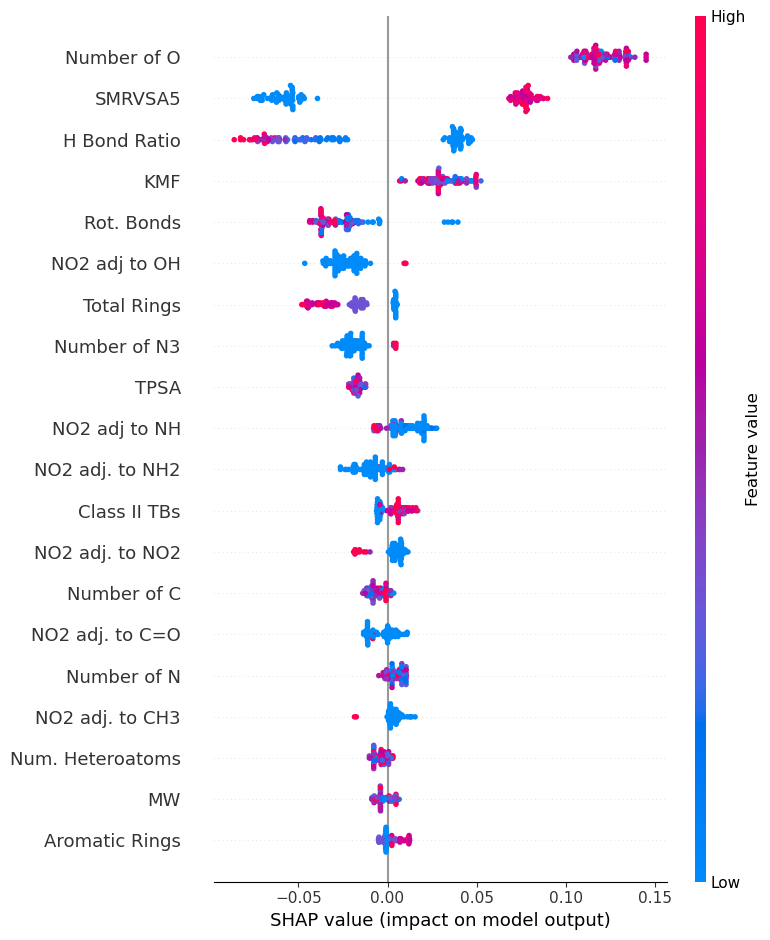

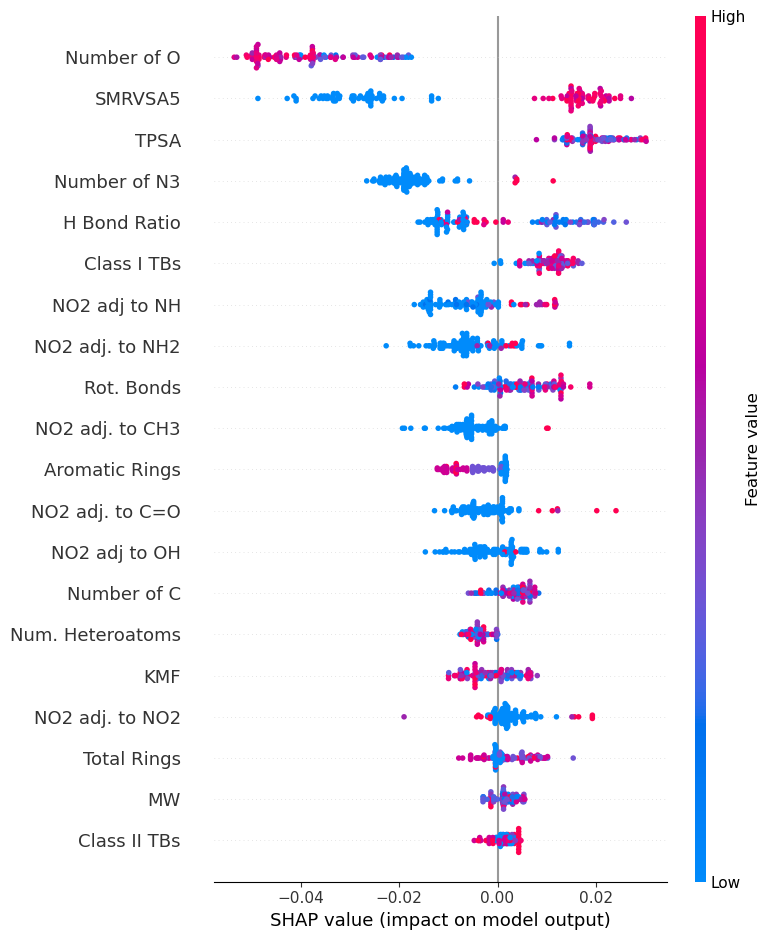

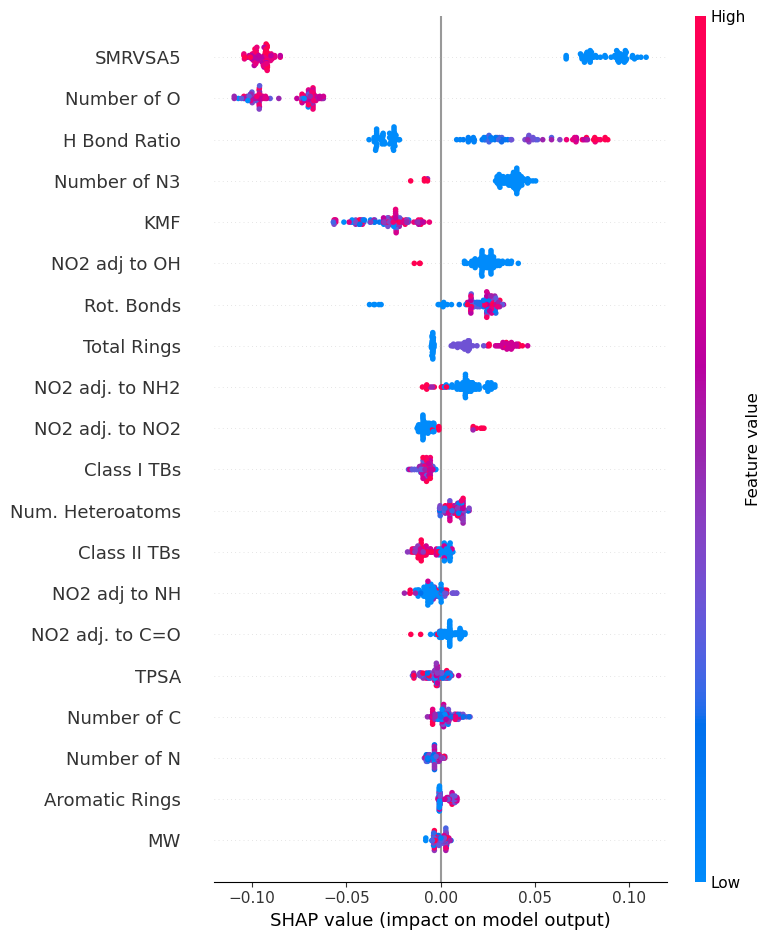

In [27]:
explainer = shap.TreeExplainer(rf_models['tertiary'])
shap_values = explainer(X_test)
for i in range(0,3):
    shap.summary_plot(shap_values[:,:,i], X_test)

## LightGBM

LightGBM (binary) Training set score: 1.000
LightGBM (binary) Test set score: 0.738
              precision    recall  f1-score   support

           0       0.65      0.70      0.67        47
           1       0.80      0.76      0.78        75

    accuracy                           0.74       122
   macro avg       0.72      0.73      0.73       122
weighted avg       0.74      0.74      0.74       122

AUC-ROC (macro): 0.779
AUC-ROC (weighted): 0.779
LightGBM (tertiary) Training set score: 0.992
LightGBM (tertiary) Test set score: 0.615
              precision    recall  f1-score   support

           0       0.64      0.66      0.65        35
           1       0.53      0.55      0.54        44
           2       0.68      0.65      0.67        43

    accuracy                           0.61       122
   macro avg       0.62      0.62      0.62       122
weighted avg       0.62      0.61      0.62       122

AUC-ROC (macro): 0.775
AUC-ROC (weighted): 0.769
LightGBM (quaternary) 

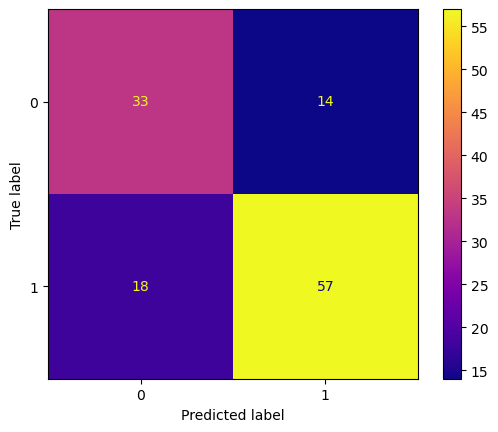

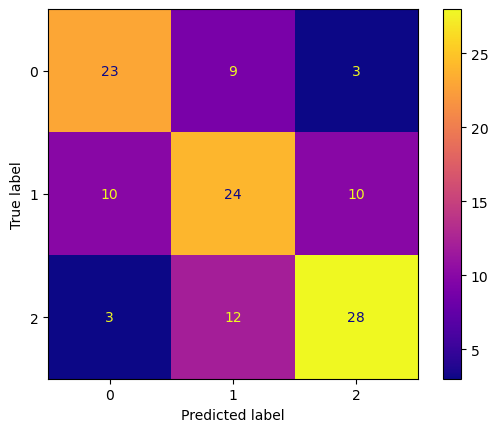

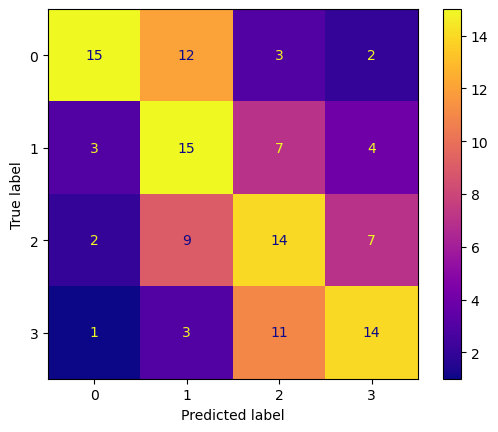

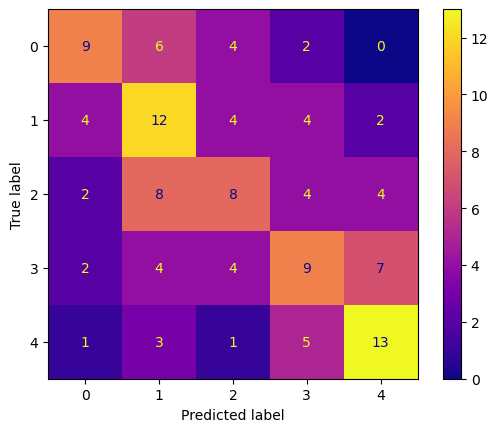

In [54]:
lgb_models = {}
for target in targets:
    objective = 'binary' if target=='binary' else 'multiclass'
    best_params = {
    # General parameters
    "booster":'gbtree',
    "nthread":16,
    
    # Booster parameters
    "n_estimators":500,          
    "eta":0.01,                            
    "colsample_bytree": lightgb_params[target]['colsample_bytree'],
    "num_leaves" : int(lightgb_params[target]['num_leaves']),
    'max_depth': int(lightgb_params[target]['max_depth']),
    
    "objective":objective,
    "verbose":-1                  
    }
    lgb_models[target] = run_model(X_train_scaled, y_train_dict[target], X_test_scaled, y_test_dict[target], best_params, target, 'LightGBM')

In [29]:
print("GB feature importances:", lgb_models['quaternary'].feature_importances_)

fourclsgb = lgb_models['quaternary'].feature_importances_
np.savetxt("4clsgbimportances_.csv", fourclsgb)

GB feature importances: [2022  560  560  146 1357 1416 2697  381  249  128    1 1014 1721  856
 1023 1017  509  666  198   94   31    0    0  521]


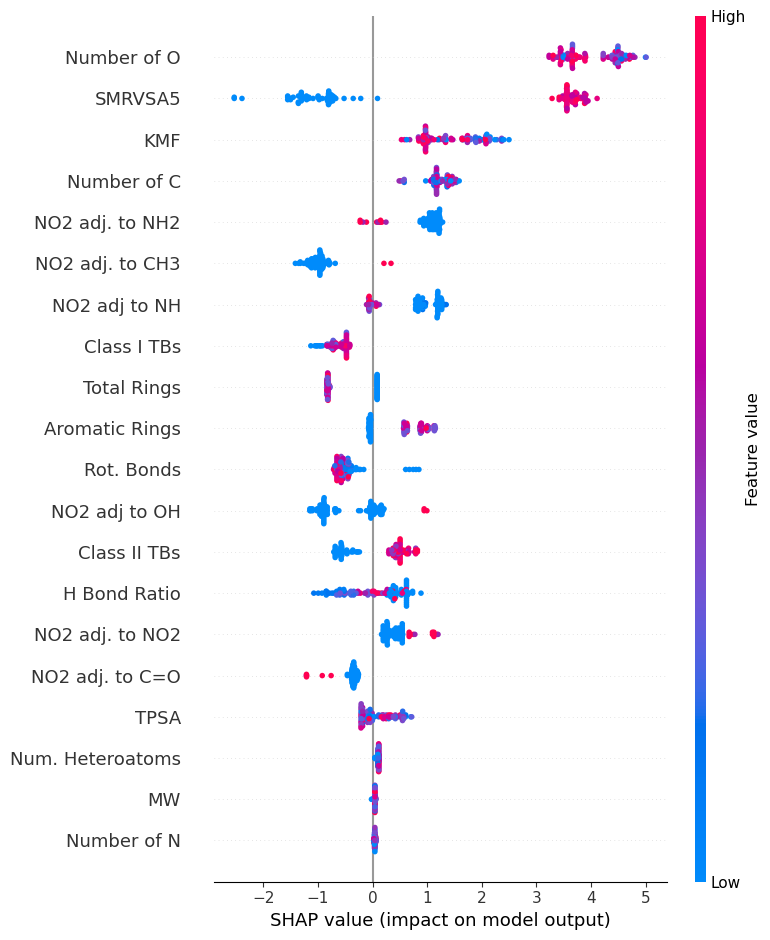

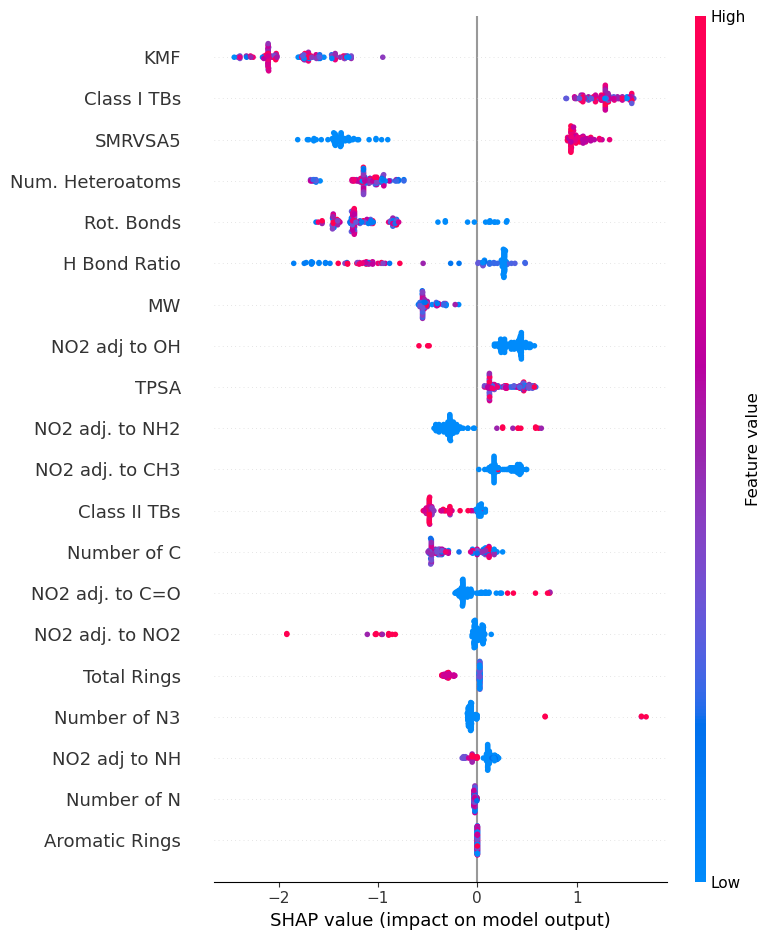

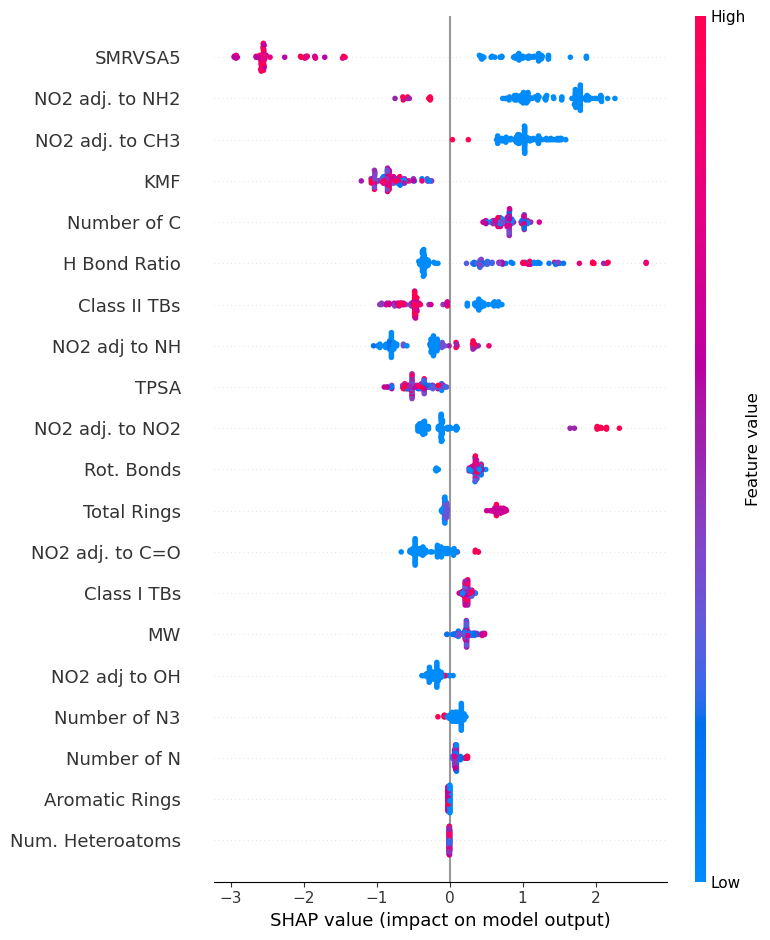

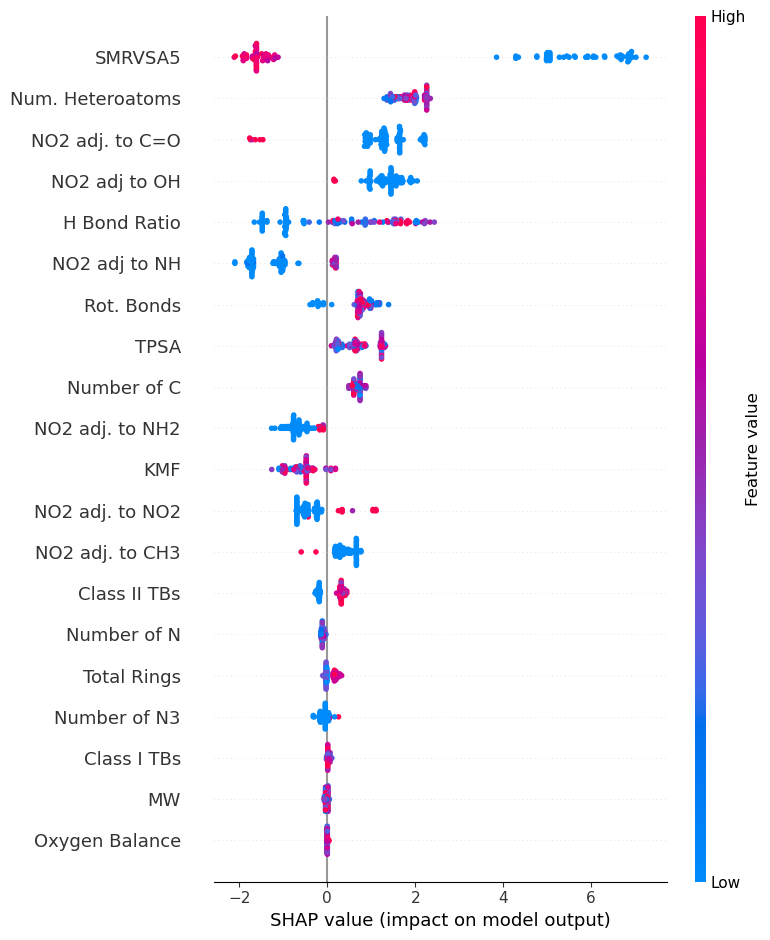

In [30]:
explainer = shap.TreeExplainer(lgb_models['quaternary'])
shap_values = explainer(X_test)
for i in range(0,4):
    shap.summary_plot(shap_values[:,:,i], X_test)

In [31]:
print("GB feature importances:", lgb_models['quintenary'].feature_importances_)

fiveclsgb = lgb_models['quintenary'].feature_importances_
np.savetxt("5clsgbimportances_.csv", fiveclsgb)

GB feature importances: [1677  541  409  114 1735 1264 2765  303  246  168    5  918 1560  656
 1055  882  612  734  369  134   33    0    0  611]


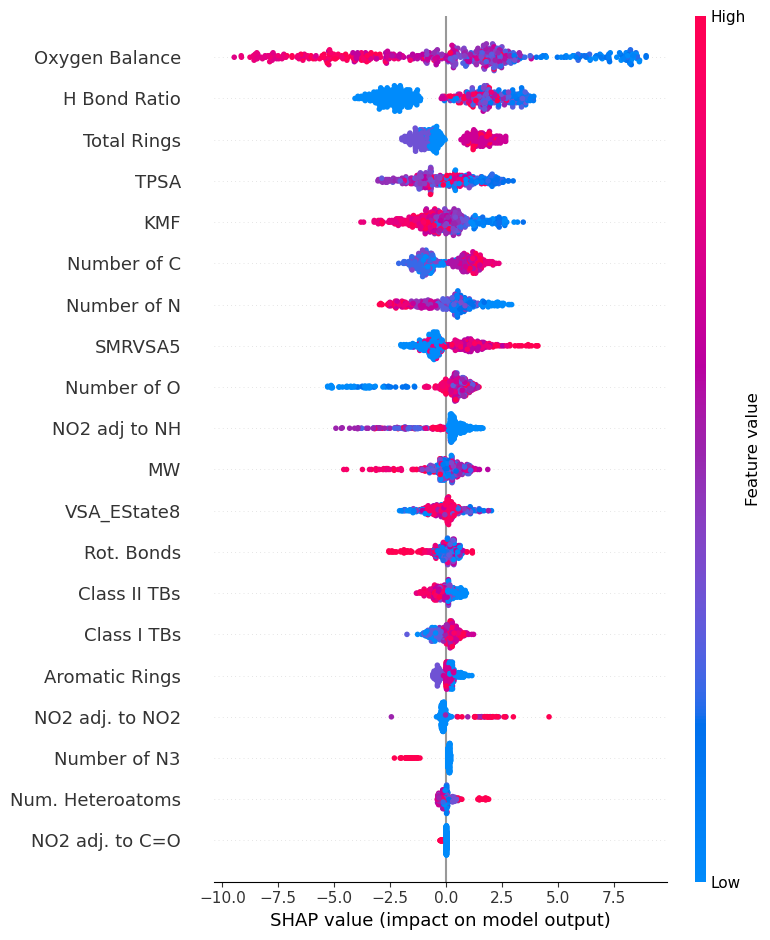

In [33]:
explainer = shap.TreeExplainer(lgb_models['binary'])
shap_values = explainer(X)
shap.summary_plot(shap_values, X)

#### Plots from best models

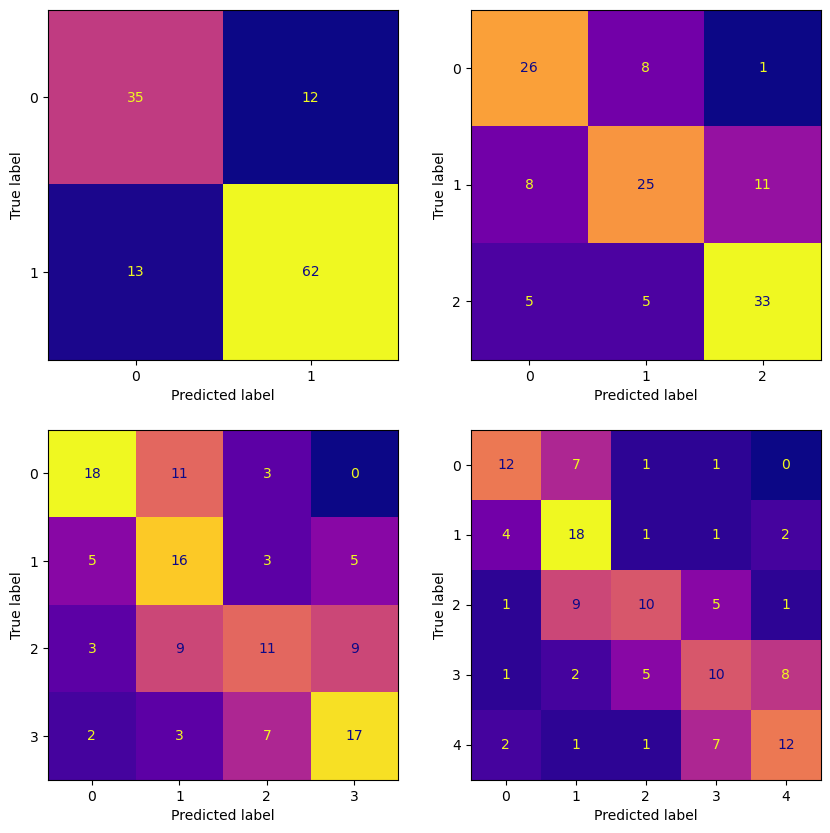

In [58]:
fig, axs = plt.subplots(2,2, figsize=(10,10))
preds_2 = rf_models['binary'].predict(X_test_scaled)
preds_3 = rf_models['tertiary'].predict(X_test_scaled)
preds_4 = rf_models['quaternary'].predict(X_test_scaled)
preds_5 = logreg_models['quintenary'].predict(X_test_scaled)

cm2 = confusion_matrix(y_test_dict['binary'], preds_2)
cm3 = confusion_matrix(y_test_dict['tertiary'], preds_3)
cm4 = confusion_matrix(y_test_dict['quaternary'], preds_4)
cm5 = confusion_matrix(y_test_dict['quintenary'], preds_5)

mx2 = ConfusionMatrixDisplay(cm2)
mx3 = ConfusionMatrixDisplay(cm3)
mx4 = ConfusionMatrixDisplay(cm4)
mx5 = ConfusionMatrixDisplay(cm5)

mx2.plot(cmap='plasma',ax=axs[0][0], colorbar=False)
# axs[0][0].set_title('Binary Random Forest')
mx3.plot(cmap='plasma',ax=axs[0][1], colorbar=False)
# axs[0][1].set_title('Tertiary Random Forest')
mx4.plot(cmap='plasma',ax=axs[1][0], colorbar=False)
# axs[1][0].set_title('Quarternary Random Forest')
mx5.plot(cmap='plasma',ax=axs[1][1], colorbar=False)
# axs[1][1].set_title('Quintenary Logistic Regression')

#### SHAP plots

In [59]:
def plot_shap(model, dataset, model_type):
    if model_type in ['SVC','LogReg']:
        explainer = shap.LinearExplainer(model, dataset)
    else:
        explainer = shap.TreeExplainer(model)
    shap_values = explainer(dataset)
    for i in range(len(set(model.predict(dataset)))):
        shap.summary_plot(shap_values[:,:,i], dataset)        

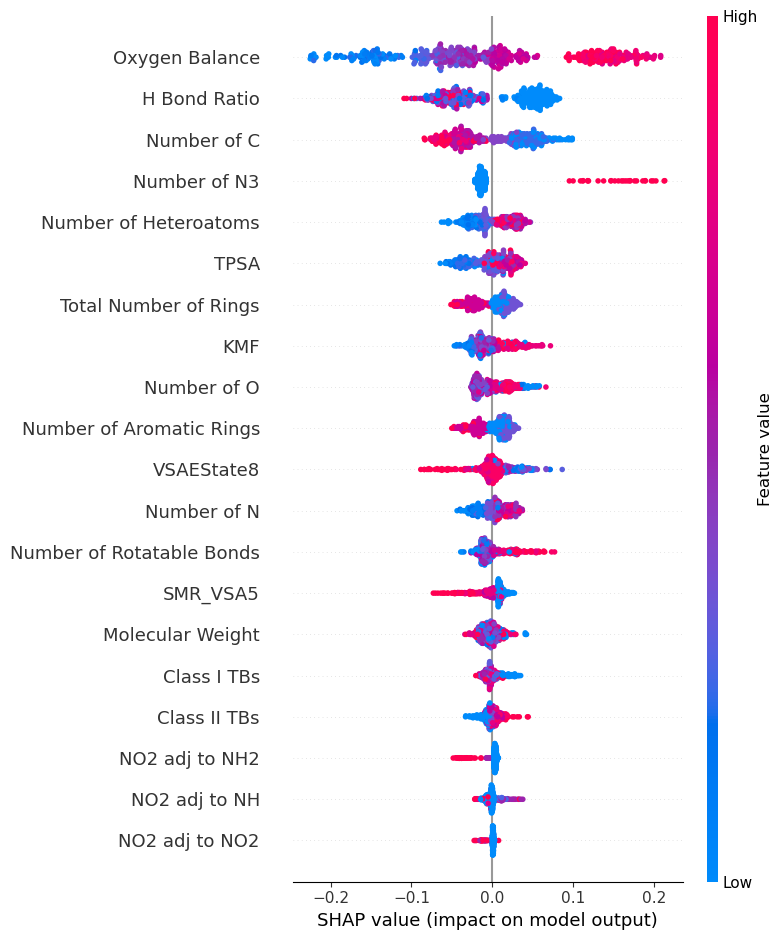

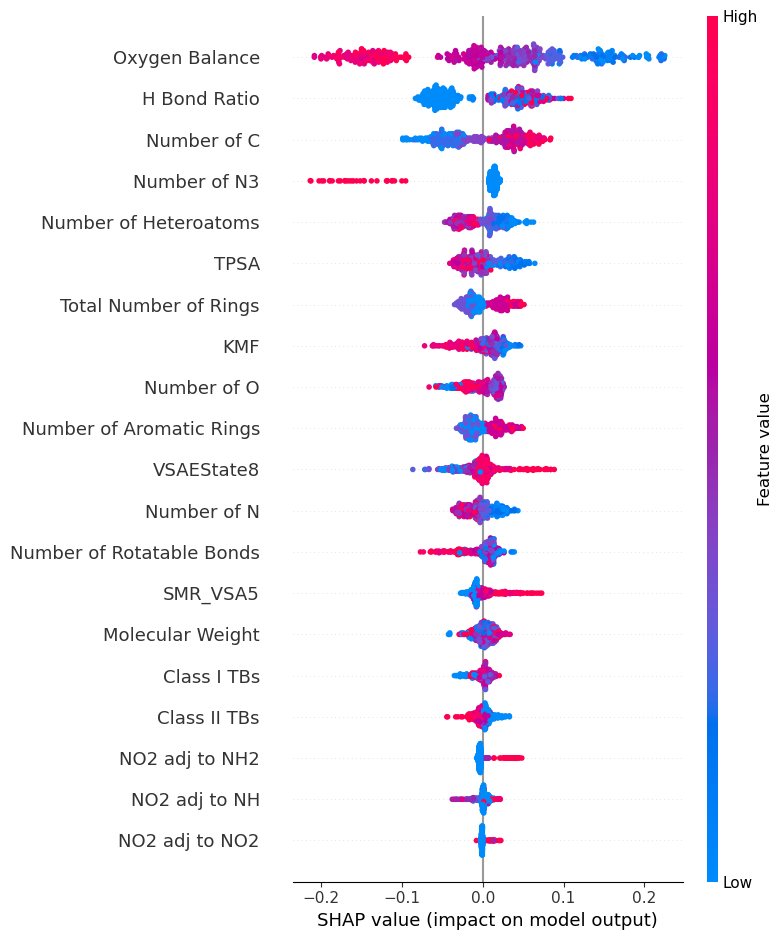

In [63]:
plot_shap(rf_models['binary'], X, 'RF')

In [67]:
X_train_scaled.to_csv('train_data.csv')